<a href="https://colab.research.google.com/github/lmcanavals/cs_topics/blob/main/0901_hospitals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install -U ortools &> /dev/null

In [ ]:
from ortools.sat.python import cp_model
from random import randint as rndi
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (40, 15)

In [ ]:
n_hospitals = 5
n_patients = 500

n_beds_per_hospitals = [rndi(10, 100) for _ in range(n_hospitals)]
print(n_beds_per_hospitals)
n_beds_total = sum(n_beds_per_hospitals)
print(n_beds_total)

[22, 80, 65, 51, 44]
262


In [ ]:
patient_locs = [(rndi(1, 100), rndi(1, 100)) for _ in range(n_patients)]
print(patient_locs[:10])
hospital_locs = [(rndi(1, 100), rndi(1, 100)) for _ in range(n_hospitals)]
print(hospital_locs)
patient_severities = [rndi(1, 5) for _ in range(n_patients)]
print(patient_severities[:20])

[(78, 44), (49, 10), (43, 85), (26, 1), (85, 73), (44, 22), (81, 16), (15, 65), (28, 79), (55, 98)]
[(12, 13), (54, 73), (7, 40), (84, 64), (27, 23)]
[4, 1, 3, 1, 2, 1, 1, 1, 4, 2, 2, 4, 2, 5, 2, 2, 3, 4, 3, 1]


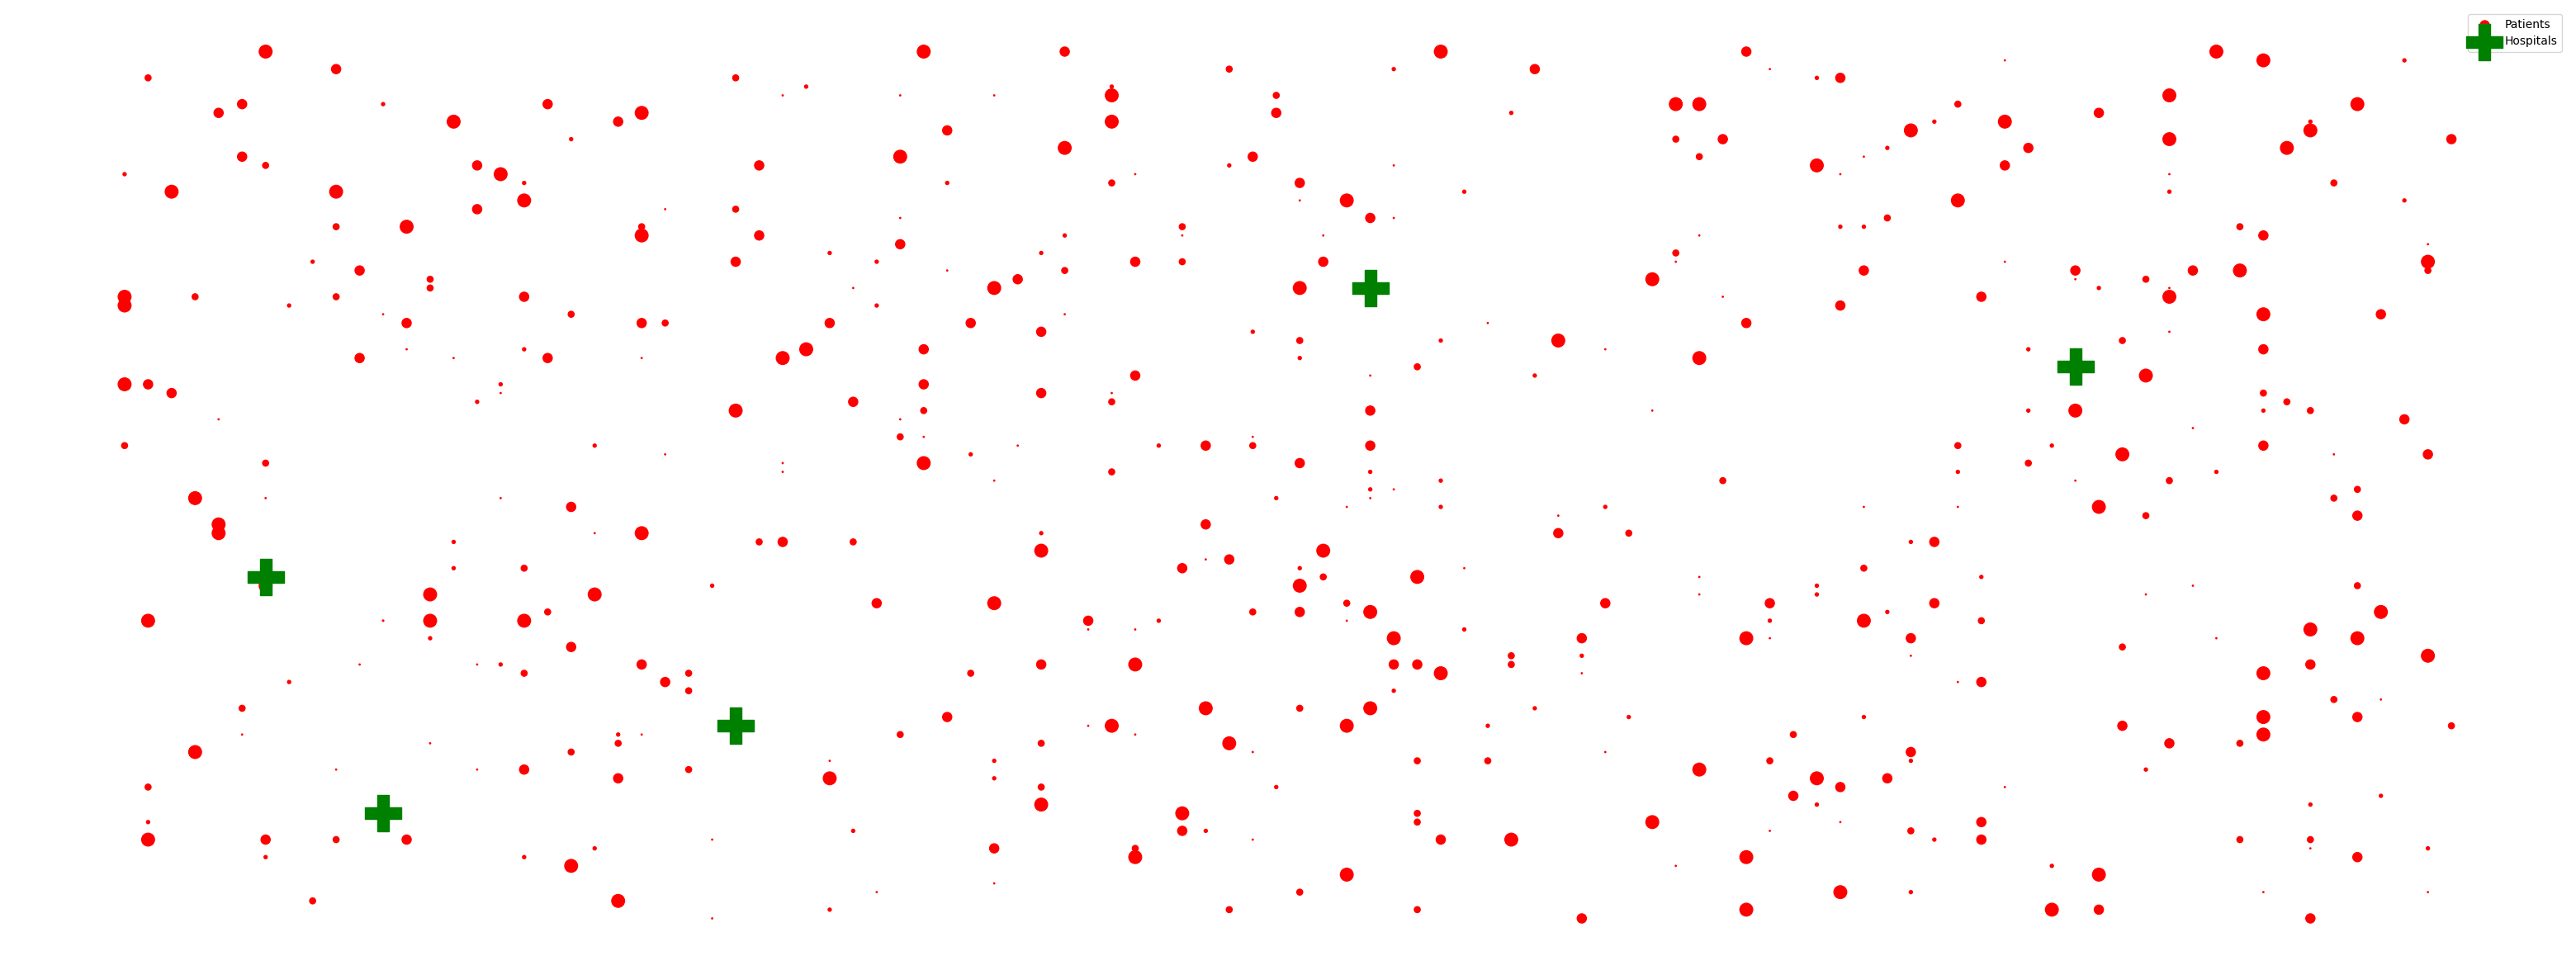

In [ ]:
severity_size = [sev**3 for sev in patient_severities]
plt.scatter(*zip(*patient_locs), s=severity_size, c='r', label="Patients")
plt.scatter(*zip(*hospital_locs), s=1000, c='g', marker='P', label="Hospitals")
plt.legend()
plt.axis('off')
plt.show()

In [ ]:
model = cp_model.CpModel()

x = {}
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        for k in range(n_patients):
            x[(i, j, k)] = model.NewBoolVar(f"x_{i}_{j}_{k}")

## First constrain

At most 1 patient per bed

$$
\forall i \in H, \forall j \in B_i, \sum_{k \in P}{x_{ijk}\le1}
$$

In [ ]:
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        model.Add(sum([x[(i, j, k)] for k in range(n_patients)]) <= 1)

## Second constrain

Patients assigned to at most 1 bed

$$
\forall k \in P, \sum_{i \in H}\sum_{j \in B_i}{x_{ijk} \le 1}
$$

In [ ]:
for k in range(n_patients):
    n_pat_per_bed_hosp = []
    for i in range(n_hospitals):
        n_pat_per_bed_hosp.append(sum(x[(i, j, k)]
                                      for j in range(n_beds_per_hospitals[i])))
        model.Add(sum(n_pat_per_bed_hosp) <= 1)

## Soft Constrain 1

Try to get patient to the closest hospital

$$
\max_{sol}{\sum_{i \in H}{\sum_{j \in B_i}{\sum_{k \in P}{x_{ijk}}}}}
$$

In [ ]:
import numpy as np

def dist(p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    return sum((p1-p2)**2)**.5

assert dist((0, 0), (0, 5)) == 5
assert dist((0, 0), (3, 4)) == 5

In [ ]:
max_dist = 0
for i in range(n_hospitals):
    for k in range(n_patients):
        d = dist(hospital_locs[i], patient_locs[k])
        if max_dist < d:
            max_dist = d

pref = []
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        for k in range(n_patients):
            pref += [x[(i,j,k)]*(100 - 100*dist(patient_locs[k], hospital_locs[i]) / max_dist + 100 * patient_severities[k] / 5)]

model.Maximize(sum(pref))

## Solving time!

In [ ]:
solver = cp_model.CpSolver()
status = solver.Solve(model)

In [ ]:
if status == cp_model.OPTIMAL:
    print("Time:", solver.WallTime())
    for i in range(n_hospitals):
        print(f"Hospital {i} has {n_beds_per_hospitals[i]} beds:")
        for j in range(n_beds_per_hospitals[i]):
            print(f"bed {j:3}:", end=" ")
            for k in range(n_patients):
                if solver.Value(x[(i, j, k)]):
                    print(f"patient {k}")
        print()

In [ ]:
plot_lines = [[] for _ in range(n_hospitals)]
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        for k in range(n_patients):
            if solver.Value(x[(i, j, k)]):
                abcise_line = [hospital_locs[i][0], patient_locs[k][0]]
                ordered_line = [hospital_locs[i][1], patient_locs[k][1]]
                plot_lines[i].append([abcise_line, ordered_line])

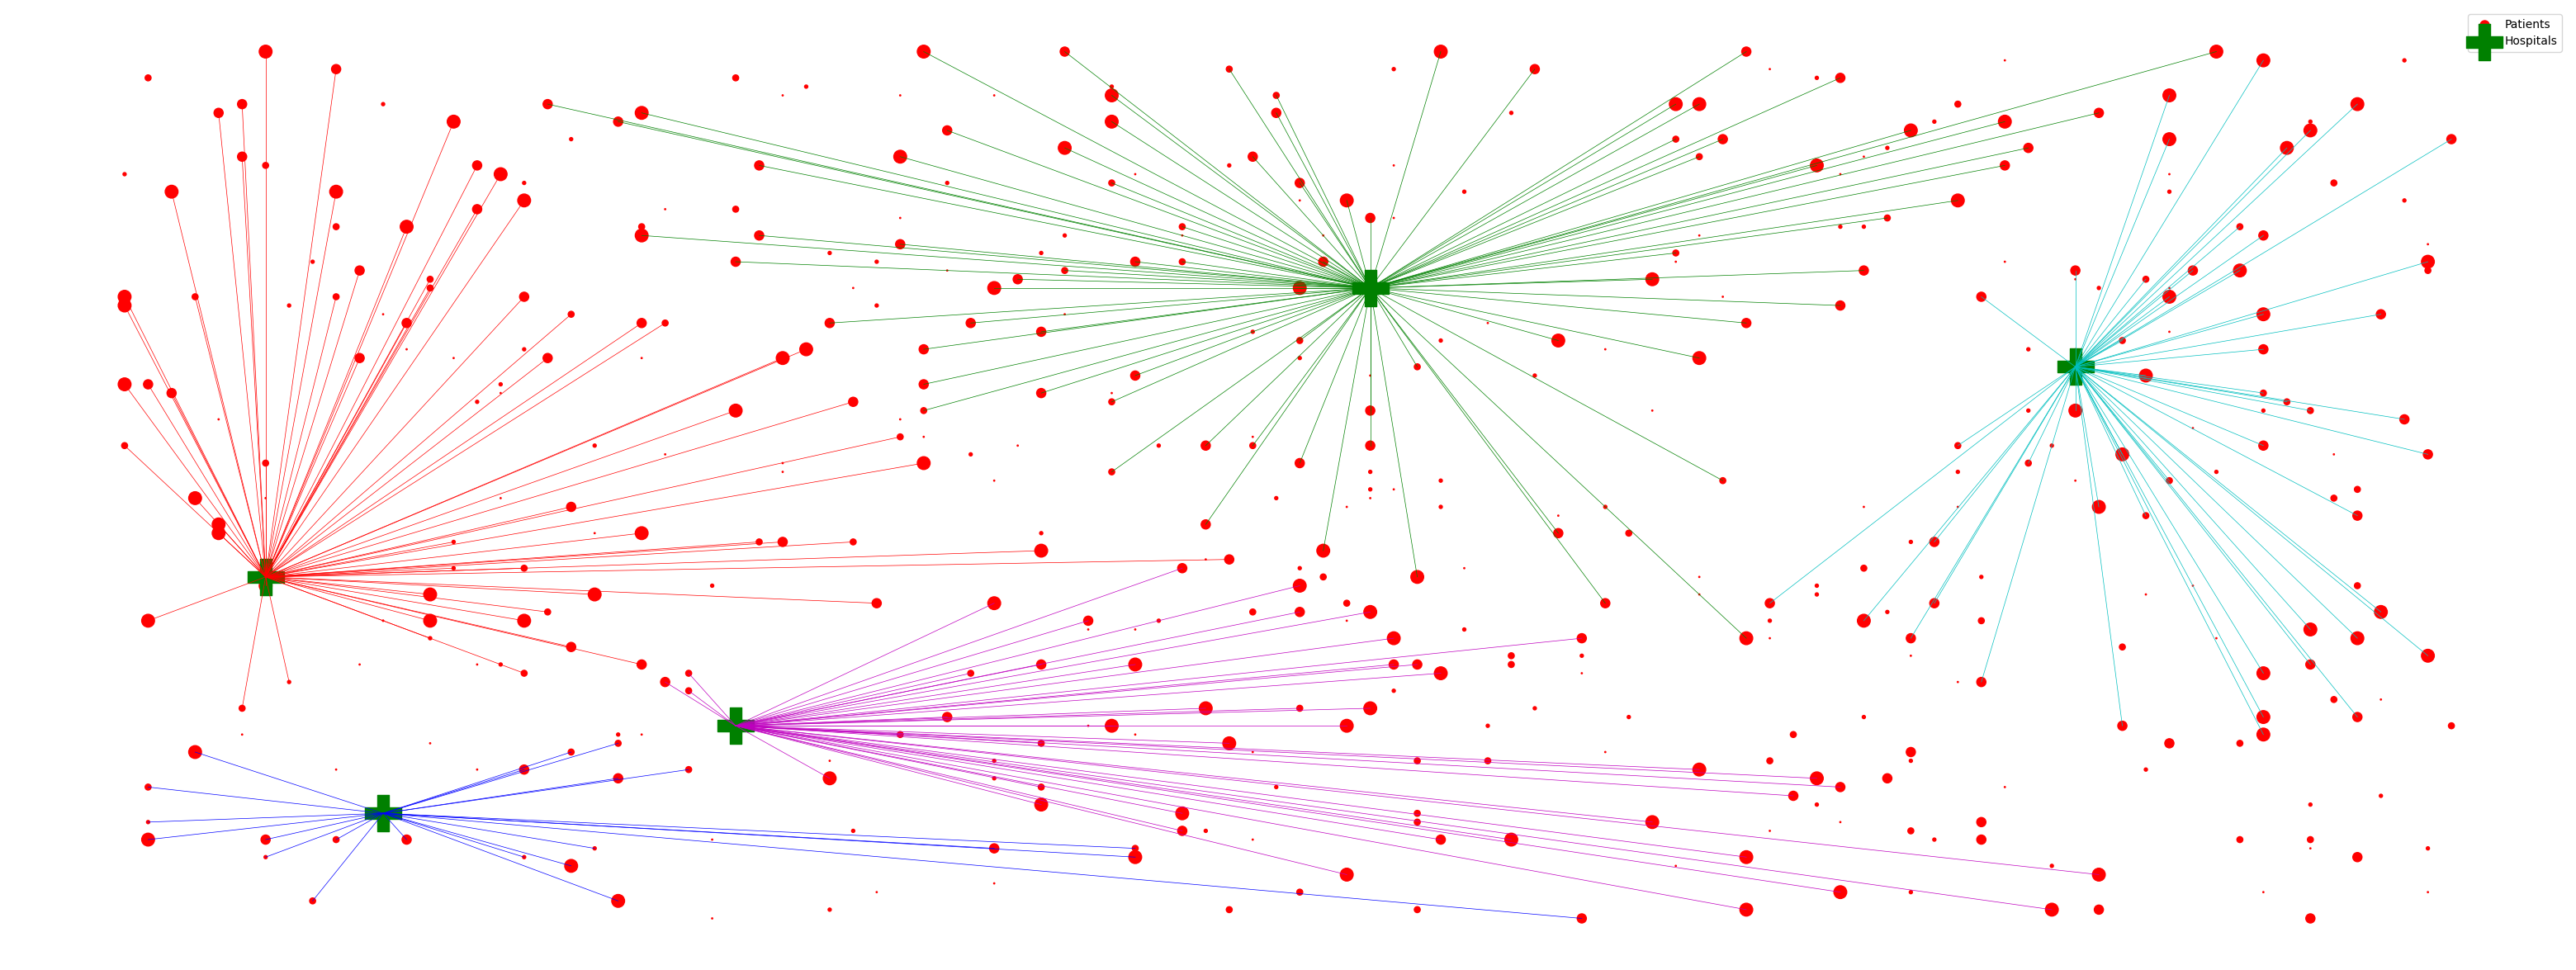

In [ ]:
from itertools import cycle

colors = cycle("bgrcmk")
for i in range(n_hospitals):
    c = next(colors)
    for x, y in plot_lines[i]:
        plt.plot(x, y, c=c, linewidth=.5)
plt.scatter(*zip(*patient_locs), s=severity_size, c='r', label="Patients")
plt.scatter(*zip(*hospital_locs), s=1000, c='g', marker='P', label="Hospitals")
plt.legend()
plt.axis('off')
plt.show()